In [1]:
# Import necessary libraries

import imp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mlb
import matplotlib.pyplot as plt
import os
import io

# to display images

import PIL
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import array_to_img

from pyspark import SparkContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, BinaryType
from pyspark.ml.linalg import Vectors, DenseVector, VectorUDT, Vectors 
from pyspark.ml.feature import StandardScaler, PCA, VectorAssembler
from pyspark.ml.image import ImageSchema
from pyspark.conf import SparkConf

import pyspark.sql.functions as F
from pyspark.sql.functions import *


#from keras.applications import inception_v3, xception, ResNet50
#from sparkdl import DeepImageFeaturizer

# setting
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns=200
pd.options.display.max_rows=200

/tmp/ipykernel_285821/1139951900.py:3: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp
2022-10-09 21:13:58.474483: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-09 21:13:58.733462: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-09 21:13:58.789236: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcu

## scan the work / data directories and files 

In [2]:
os.getcwd()

'/home/houssein/Documents/openclassrooms/p8/deployez_un_modele_dans_le_cloud'

In [3]:
os.listdir()

['Franck_P8_Notebook_local.ipynb',
 'p8_pretreatment_reduction_4.ipynb',
 'p8_pretreatment_reduction_2.ipynb',
 'venv',
 'Franck_P8_Notebook_ec2.ipynb',
 '.idea',
 '.ipynb_checkpoints',
 'p8_pretreatment_reduction.ipynb',
 'data',
 'p8_pretreatment_reduction_3.ipynb',
 'p8_pretreatment_reduction_1.ipynb',
 'p8_pretreatment_reduction_5.ipynb']

In [4]:
os.listdir('data/')

['fruits-360-original-size', 'fruits-360']

In [5]:
os.listdir('data/fruits-360-original-size')

['readme.md', 'Validation', 'Papers', 'Test', 'Meta', 'Training']

In [6]:
os.listdir('data/fruits-360/')

['papers', 'LICENSE', 'readme.md', 'test-multiple_fruits', 'Test', 'Training']

In [7]:
os.listdir('data/fruits-360-original-size/Training/')

['apple_golden_2',
 'apple_red_delicios_1',
 'apple_red_3',
 'apple_golden_3',
 'cucumber_3',
 'apple_red_1',
 'apple_6',
 'apple_red_yellow_1',
 'apple_pink_lady_1',
 'eggplant_violet_1',
 'cucumber_1',
 'pear_3',
 'apple_rotten_1',
 'zucchini_dark_1',
 'apple_hit_1',
 'pear_1',
 'cabbage_white_1',
 'apple_red_2',
 'apple_granny_smith_1',
 'apple_braeburn_1',
 'zucchini_1',
 'apple_golden_1',
 'apple_crimson_snow_1',
 'carrot_1']

In [8]:
len(os.listdir('data/fruits-360-original-size/Training/'))

24

In [9]:
categories = os.listdir('data/fruits-360-original-size/Training/')
for i in range(len(categories)):
    categories[i] = categories[i].lower()
    cat = categories[i].split()
    categories[i] = '_'.join(c for c in cat)
    # print(categories[i])
d = {'categories': categories}
df = pd.DataFrame(data=d)
df = df.sort_values('categories')
df.reset_index().drop(columns='index')

,categories
0,apple_6
1,apple_braeburn_1
2,apple_crimson_snow_1
3,apple_golden_1
4,apple_golden_2
5,apple_golden_3
6,apple_granny_smith_1
7,apple_hit_1
8,apple_pink_lady_1
9,apple_red_1


In [10]:
categories = os.listdir('data/fruits-360-original-size/Training/')
for category in categories:
    category = category.lower()
    cat = category.split()
    category = '_'.join(c for c in cat)
    print(category)
d = {'categories': categories}
df = pd.DataFrame(data=d)
df

apple_golden_2
apple_red_delicios_1
apple_red_3
apple_golden_3
cucumber_3
apple_red_1
apple_6
apple_red_yellow_1
apple_pink_lady_1
eggplant_violet_1
cucumber_1
pear_3
apple_rotten_1
zucchini_dark_1
apple_hit_1
pear_1
cabbage_white_1
apple_red_2
apple_granny_smith_1
apple_braeburn_1
zucchini_1
apple_golden_1
apple_crimson_snow_1
carrot_1


,categories
0,apple_golden_2
1,apple_red_delicios_1
2,apple_red_3
3,apple_golden_3
4,cucumber_3
5,apple_red_1
6,apple_6
7,apple_red_yellow_1
8,apple_pink_lady_1
9,eggplant_violet_1


In [11]:
len(os.listdir('data/fruits-360-original-size/Training/'))

24

In [12]:
len(os.listdir('data/fruits-360-original-size/Training/cabbage_white_1/'))

96

## spark code for reading jpg files, extract features & excute a pca

In [13]:
# spark session creation 
#spark = SparkSession.builder.master("local[16]").appName("Fruits").getOrCreate()
#conf=SparkConf()


spark = SparkSession.builder \
      .master("local[16]") \
      .appName("Fruits") \
      .config("spark.executor.memory", "8g") \
      .config("spark.driver.memory", "8g") \
      .getOrCreate()

spark.sparkContext.setLogLevel("OFF")

sc = SparkContext.getOrCreate()

spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/09 21:14:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [14]:
os.walk('data/fruits-360-original-size/Training/')

<generator object _walk at 0x7f6fb84afca0>

In [15]:
# for roots,dirs,files in os.walk('data/fruits-360/Test/'):
#     for file in files:
#         print(roots,file)

In [16]:
columns = ["path", "category", "filename", "image"]
l1 = []
for roots,dirs,files in os.walk('data/fruits-360-original-size/Training/'):
    for file in files:
        filename = os.path.join(roots,file)
        l = (roots, roots[39:], filename, file)
        l1.append(l)
    
rdd = spark.sparkContext.parallelize(l1)
df = rdd.toDF(columns)
df.show()

+--------------------+--------------+--------------------+----------+
|                path|      category|            filename|     image|
+--------------------+--------------+--------------------+----------+
|data/fruits-360-o...|apple_golden_2|data/fruits-360-o...| r1_28.jpg|
|data/fruits-360-o...|apple_golden_2|data/fruits-360-o...|r1_200.jpg|
|data/fruits-360-o...|apple_golden_2|data/fruits-360-o...|r1_226.jpg|
|data/fruits-360-o...|apple_golden_2|data/fruits-360-o...|  r0_4.jpg|
|data/fruits-360-o...|apple_golden_2|data/fruits-360-o...| r0_72.jpg|
|data/fruits-360-o...|apple_golden_2|data/fruits-360-o...|r0_174.jpg|
|data/fruits-360-o...|apple_golden_2|data/fruits-360-o...|  r1_0.jpg|
|data/fruits-360-o...|apple_golden_2|data/fruits-360-o...|r0_250.jpg|
|data/fruits-360-o...|apple_golden_2|data/fruits-360-o...| r0_60.jpg|
|data/fruits-360-o...|apple_golden_2|data/fruits-360-o...|r0_242.jpg|
|data/fruits-360-o...|apple_golden_2|data/fruits-360-o...| r0_44.jpg|
|data/fruits-360-o..

In [17]:
print((df.count(), len(df.columns)))

(6231, 4)


In [18]:
df.select('filename').show(1, truncate=False)

+---------------------------------------------------------------+
|filename                                                       |
+---------------------------------------------------------------+
|data/fruits-360-original-size/Training/apple_golden_2/r1_28.jpg|
+---------------------------------------------------------------+
only showing top 1 row



## read images with tensorflow methodes

In [19]:
img_0_0 = df.select("filename").collect()[0][0]
print(img_0_0)

data/fruits-360-original-size/Training/apple_golden_2/r1_28.jpg


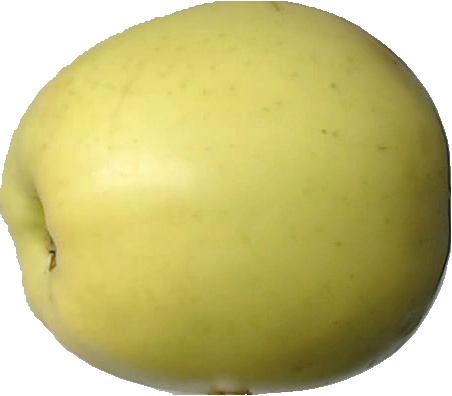

In [20]:
load_img(img_0_0)

2022-10-09 21:14:12.554965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 21:14:12.555181: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/houssein/Documents/openclassrooms/p8/deployez_un_modele_dans_le_cloud/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-10-09 21:14:12.555363: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/houssein/Documents/openclassrooms/p8/deployez_un_modele_dans_le_cloud/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-10-09 21:14:12.555509: W tens

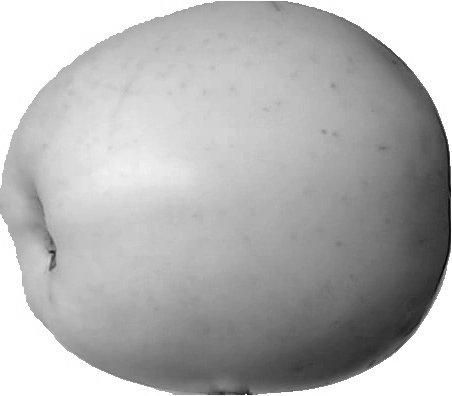

In [21]:
array_to_img(rgb_to_grayscale(img_to_array(load_img(img_0_0))))

In [22]:
img_to_array(array_to_img(rgb_to_grayscale(img_to_array(load_img(img_0_0)))))

array([[[255.],
        [255.],
        [255.],
        ...,
        [255.],
        [255.],
        [255.]],

       [[255.],
        [255.],
        [255.],
        ...,
        [255.],
        [255.],
        [255.]],

       [[255.],
        [255.],
        [255.],
        ...,
        [255.],
        [255.],
        [255.]],

       ...,

       [[255.],
        [255.],
        [255.],
        ...,
        [255.],
        [255.],
        [255.]],

       [[255.],
        [255.],
        [255.],
        ...,
        [255.],
        [255.],
        [255.]],

       [[255.],
        [255.],
        [255.],
        ...,
        [255.],
        [255.],
        [255.]]], dtype=float32)

In [23]:
# Select distinct rows (unique_values)
distinctDF = df.select("path").distinct()

print(distinctDF.count())

distinctDF = distinctDF.withColumn('path_all', concat(col('path'), lit("/*") ))

distinctDF.show(truncate=False)

distinctDF.collect()[0][0]


24
+-----------------------------------------------------------+-------------------------------------------------------------+
|path                                                       |path_all                                                     |
+-----------------------------------------------------------+-------------------------------------------------------------+
|data/fruits-360-original-size/Training/apple_red_delicios_1|data/fruits-360-original-size/Training/apple_red_delicios_1/*|
|data/fruits-360-original-size/Training/apple_golden_2      |data/fruits-360-original-size/Training/apple_golden_2/*      |
|data/fruits-360-original-size/Training/apple_red_3         |data/fruits-360-original-size/Training/apple_red_3/*         |
|data/fruits-360-original-size/Training/apple_golden_3      |data/fruits-360-original-size/Training/apple_golden_3/*      |
|data/fruits-360-original-size/Training/cucumber_3          |data/fruits-360-original-size/Training/cucumber_3/*          |
|data

'data/fruits-360-original-size/Training/apple_red_delicios_1'

In [24]:
distinctDF.show(1, truncate=False)

+-----------------------------------------------------------+-------------------------------------------------------------+
|path                                                       |path_all                                                     |
+-----------------------------------------------------------+-------------------------------------------------------------+
|data/fruits-360-original-size/Training/apple_red_delicios_1|data/fruits-360-original-size/Training/apple_red_delicios_1/*|
+-----------------------------------------------------------+-------------------------------------------------------------+
only showing top 1 row



In [25]:
distinctDF.select('path_all').collect()[0][0]

'data/fruits-360-original-size/Training/apple_red_delicios_1/*'

In [27]:
#initiation phase first row (row = 0)
path_initiation = distinctDF.select('path_all').collect()[0][0]
img_all = spark.read.format("binaryfile").load(path_initiation)
#loop for to collect all photos
for row in range(1, 3):
    path_i = distinctDF.select('path_all').collect()[row][0]
    img_i = spark.read.format("binaryfile").load(path_i)
    img_all = img_all.union(img_i)

img_all.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [28]:
print((img_all.count(), len(img_all.columns)))

(889, 4)


In [29]:
img_df = img_all.select("path", "content")
n_rows = img_df.count()
img_df = img_df.withColumn("target", split(col("path"), "/") \
    .getItem(10))
img_df.show()

+--------------------+--------------------+--------------------+
|                path|             content|              target|
+--------------------+--------------------+--------------------+
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_delicios_1|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_delicios_1|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_delicios_1|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_delicios_1|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_delicios_1|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_delicios_1|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_delicios_1|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_delicios_1|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_delicios_1|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_delicios_1|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_delicios_1|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_delicios_1|
|file:/home/housse...|[FF

In [30]:
# Les données images sont converties au format vecteur dense
ud_f = udf(lambda x: Vectors.dense(x), VectorUDT())
img_df = img_df.withColumn('vecs', ud_f('content'))
img_df.show()

+--------------------+--------------------+--------------------+--------------------+
|                path|             content|              target|                vecs|
+--------------------+--------------------+--------------------+--------------------+
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_delicios_1|[255.0,216.0,255....|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_delicios_1|[255.0,216.0,255....|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_delicios_1|[255.0,216.0,255....|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_delicios_1|[255.0,216.0,255....|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_delicios_1|[255.0,216.0,255....|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_delicios_1|[255.0,216.0,255....|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_delicios_1|[255.0,216.0,255....|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_delicios_1|[255.0,216.0,255....|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_d

In [31]:
len(img_df.collect()[0]['vecs'])

71926

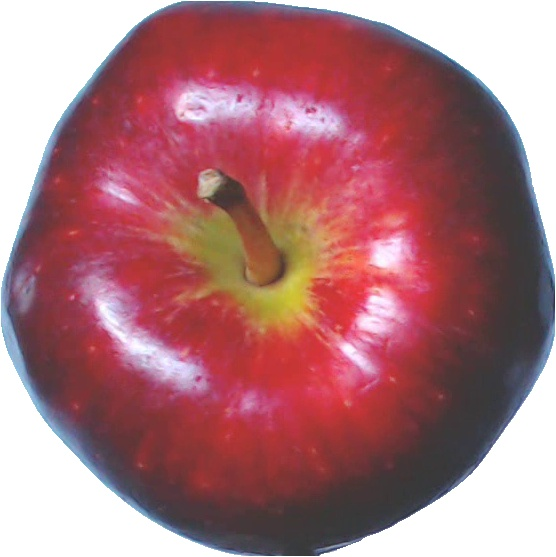

In [32]:
# Take first image of dataset
img_example = img_df.collect()[0]["content"]
# Convert from bytes to jpeg using tensorflow
img_example = load_img(io.BytesIO(img_example))
img_example

In [33]:
def resize_sq_fill_image(img, sq_size=224, fill_col=(255,255,255),
                 interpolation=Image.ANTIALIAS):
    '''
    this function takes an image, resizes the image and fills the non existing space
    with custom color

    Argumants:
        img: image in np or PIL format    
        sq_size: size request    
        fill_col: fill color request
    
    returns:
        new_img: image resized with fill color
    '''    
    w, h = img.size
    if h != w:
        dif = h if h > w else w
        new_img = Image.new('RGB', (dif, dif), fill_col)
        new_img.paste(img, (int((dif - w) / 2), int((dif - h) / 2)))
        img = new_img
    
    # Change format to np.array and resize with cv2
    new_img = cv2.resize(np.asarray(img), (sq_size, sq_size), interpolation)
    return np.array(new_img)

In [34]:
img_resize = resize_sq_fill_image(img_example)

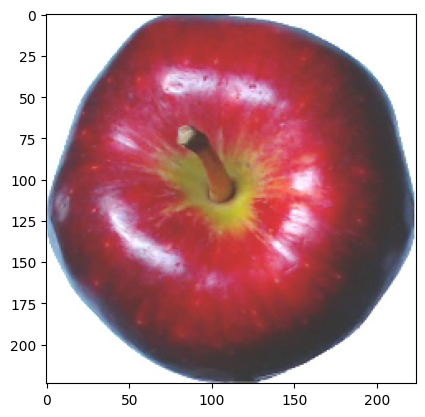

In [35]:
plt.imshow(img_resize)

In [35]:
#initiation phase first row (row = 0)
path_initiation = distinctDF.select('path_all').collect()[0][0]
img_all_1 = spark.read.format("image").load(path_initiation)
#loop for to collect all photos
for row in range(1, 2):
    path_i = distinctDF.select('path_all').collect()[row][0]
    img_i_1 = spark.read.format("image").load(path_i)
    img_all_1 = img_all_1.union(img_i_1)

img_all_1.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [36]:
print((img_all_1.count(), len(img_all_1.columns)))

(608, 1)


In [37]:
img_df_1 = img_all_1.select("image.origin", 'image.nChannels', "image.width", "image.height","image.mode", 
   "image.data")
img_df_1.show()

+--------------------+---------+-----+------+----+--------------------+
|              origin|nChannels|width|height|mode|                data|
+--------------------+---------+-----+------+----+--------------------+
|file:/home/housse...|        3|  556|   557|  16|[FF FF FF FF FF F...|
|file:/home/housse...|        3|  551|   555|  16|[FF FF FF FF FF F...|
|file:/home/housse...|        3|  553|   556|  16|[FF FF FF FF FF F...|
|file:/home/housse...|        3|  549|   554|  16|[FF FF FF FF FF F...|
|file:/home/housse...|        3|  559|   559|  16|[FF FF FF FF FF F...|
|file:/home/housse...|        3|  546|   554|  16|[FF FF FF FF FF F...|
|file:/home/housse...|        3|  564|   563|  16|[FF FF FF FF FF F...|
|file:/home/housse...|        3|  564|   561|  16|[FF FF FF FF FF F...|
|file:/home/housse...|        3|  561|   559|  16|[FF FF FF FF FF F...|
|file:/home/housse...|        3|  566|   562|  16|[FF FF FF FF FF F...|
|file:/home/housse...|        3|  544|   554|  16|[FF FF FF FF F

In [42]:
len(img_df_1.collect()[0]['data'])

In [39]:
# Les données images sont converties au format vecteur dense
ud_f = udf(lambda x: Vectors.dense(x), VectorUDT())
img_df_1 = img_df_1.withColumn('vecs', ud_f('data'))
img_df_1.show()

+--------------------+---------+-----+------+----+--------------------+--------------------+
|              origin|nChannels|width|height|mode|                data|                vecs|
+--------------------+---------+-----+------+----+--------------------+--------------------+
|file:/home/housse...|        3|  556|   557|  16|[FF FF FF FF FF F...|[255.0,255.0,255....|
|file:/home/housse...|        3|  551|   555|  16|[FF FF FF FF FF F...|[255.0,255.0,255....|
|file:/home/housse...|        3|  553|   556|  16|[FF FF FF FF FF F...|[255.0,255.0,255....|
|file:/home/housse...|        3|  549|   554|  16|[FF FF FF FF FF F...|[255.0,255.0,255....|
|file:/home/housse...|        3|  559|   559|  16|[FF FF FF FF FF F...|[255.0,255.0,255....|
|file:/home/housse...|        3|  546|   554|  16|[FF FF FF FF FF F...|[255.0,255.0,255....|
|file:/home/housse...|        3|  564|   563|  16|[FF FF FF FF FF F...|[255.0,255.0,255....|
|file:/home/housse...|        3|  564|   561|  16|[FF FF FF FF FF F...

In [1]:
# Take first image of dataset
img_example_1 = img_df_1.collect()[0]['vecs']
# Convert from bytes to jpeg
plt.imshow(io.BytesIO(img_example_1))

NameError: name 'img_df_1' is not defined

In [29]:
# Les données images sont converties au format vecteur dense
ud_f = udf(lambda x: Vectors.dense(x), VectorUDT())
df_photos_preprocess = df_photos_preprocess.withColumn('vecs', ud_f('data'))
df_photos_preprocess.show()

+--------------------+---------+-----+------+----+--------------------+--------------------+
|              origin|nChannels|width|height|mode|                data|                vecs|
+--------------------+---------+-----+------+----+--------------------+--------------------+
|file:///home/hous...|        3|  100|   100|  16|[FF FF FF FF FF F...|[255.0,255.0,255....|
|file:///home/hous...|        3|  100|   100|  16|[FF FF FF FF FF F...|[255.0,255.0,255....|
|file:///home/hous...|        3|  100|   100|  16|[FF FF FF FF FF F...|[255.0,255.0,255....|
|file:///home/hous...|        3|  100|   100|  16|[FF FF FF FF FF F...|[255.0,255.0,255....|
|file:///home/hous...|        3|  100|   100|  16|[FF FF FF FF FF F...|[255.0,255.0,255....|
|file:///home/hous...|        3|  100|   100|  16|[FF FF FF FF FF F...|[255.0,255.0,255....|
|file:///home/hous...|        3|  100|   100|  16|[FF FF FF FF FF F...|[255.0,255.0,255....|
|file:///home/hous...|        3|  100|   100|  16|[FF FF FF FF FF F...

In [31]:
df_photos_preprocess.select('vecs').show(1, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [110]:
plt.imshow(df_photos_preprocess.select('vecs').collect()[0][0])

NameError: name 'df_photos_preprocess' is not defined

In [ ]:
scaler = StandardScaler(inputCol='vecs', outputCol='scaled_vecs', withStd=True, withMean=True)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(df_photos_preprocess)
df_photos_preprocess = scalerModel.transform(df_photos_preprocess)
df_photos_preprocess.show()

+--------------------+---------+-----+------+----+--------------------+--------------------+--------------------+
|              origin|nChannels|width|height|mode|                data|                vecs|         scaled_vecs|
+--------------------+---------+-----+------+----+--------------------+--------------------+--------------------+
|file:///home/hous...|        3|  100|   100|  16|[FF FF FF FF FF F...|[255.0,255.0,255....|[0.0,0.0,0.0,0.0,...|
|file:///home/hous...|        3|  100|   100|  16|[FF FF FF FF FF F...|[255.0,255.0,255....|[0.0,0.0,0.0,0.0,...|
|file:///home/hous...|        3|  100|   100|  16|[FF FF FF FF FF F...|[255.0,255.0,255....|[0.0,0.0,0.0,0.0,...|
|file:///home/hous...|        3|  100|   100|  16|[FF FF FF FF FF F...|[255.0,255.0,255....|[0.0,0.0,0.0,0.0,...|
|file:///home/hous...|        3|  100|   100|  16|[FF FF FF FF FF F...|[255.0,255.0,255....|[0.0,0.0,0.0,0.0,...|
|file:///home/hous...|        3|  100|   100|  16|[FF FF FF FF FF F...|[255.0,255.0,255.

In [ ]:
len(df_photos_preprocess.select('scaled_vecs').collect()[0][0])

30000

In [ ]:
pca = PCA(k=3, inputCol="scaled_vecs", outputCol="PCA_vecs")
pca_model = pca.fit(df_photos_preprocess)

result = pca_model.transform(df_photos_preprocess).select("PCA_vecs")

result.show()

----------------------------------------                          (0 + 15) / 15]
Exception occurred during processing of request from ('127.0.0.1', 49894)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/houssein/Documents/openclassrooms/p8/deployez_un_modele_dans_le_cloud/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_177223/1908730531.py", line 2, in <module>
    pca_model = pca.fit(df_photos_preprocess)
  File "/home/houssein/Documents/openclassrooms/p8/deployez_un_modele_dans_le_cloud/venv/lib/python3.10/site-packages/pyspark/ml/base.py", line 205, in fit
    return self._fit(dataset)
  File "/home/houssein/Documents/openclassrooms/p8/deployez_un_modele_dans_le_cloud/venv/lib/python3.10/site-packages/pyspark/ml/wrapper.py", line 379, in _fit
    java_model = self._fit_java(dataset)
  File "/home/houssein/Documents/open

ConnectionRefusedError: [Errno 111] Connection refused